# Extraction des entités nommées (sans augmentation)

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re
import os
from typing import List, Dict, Tuple, Optional
import importlib
import models
import utils
from collections import Counter
import random
importlib.reload(models)
importlib.reload(utils)
from models.models import *
from utils.datasetloader import NERDataset
from collections import Counter
from tqdm import tqdm

from utils.fonctionsFaxtText import (
    load_jnlpba_dataset, load_ncbi_dataset, plot_class_distribution , visualize_dataset_distribution_ncbi
    
)

from utils.fonctions import (
    prepare_ncbi_for_ner,
    convert_to_standard_format,
    visualize_dataset_distribution
)

from utils.creation_vocabulaire import create_vocab,create_char_vocab,create_tag_mapping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

print("Utilisation du dispositif : ","cuda" if torch.cuda.is_available() else "cpu")

Utilisation du dispositif :  cuda


In [2]:
# -----------------------------
# Load BioWordVec embeddings (shared for both datasets)
# -----------------------------
import os
import numpy as np
import torch
from gensim.models import KeyedVectors

def load_biowordvec_embeddings(vocab, embedding_path="./embeddings/BioWordVec_PubMed_MIMICIII_d200.vec.bin"):
    """
    Load BioWordVec and create a frozen embedding matrix.
    - Uses pre-trained vectors as-is.
    - Only <UNK> and <NUM> are left as trainable (random init).
    - <PAD> is zeroed and frozen.
    """
    print("📥 Loading BioWordVec PubMed/MIMIC-III embeddings (200d)...")
    
    # Load BioWordVec
    if not os.path.exists(embedding_path):
        raise FileNotFoundError(f"BioWordVec not found at {embedding_path}. Please download it.")
    
    kv = KeyedVectors.load_word2vec_format(embedding_path, binary=True, unicode_errors='ignore')
    print(f"✅ BioWordVec loaded: {len(kv)} words, {kv.vector_size} dims")

    # Build embedding matrix
    vocab_size = len(vocab)
    emb_dim = kv.vector_size
    embedding_matrix = np.zeros((vocab_size, emb_dim), dtype=np.float32)  # <PAD> = 0
    
    unk_idx = vocab["<UNK>"]
    num_idx = vocab.get("<NUM>", -1)
    
    # Fill known words
    found, not_found = 0, 0
    for word, idx in vocab.items():
        if idx == 0:  # <PAD>
            continue
        elif idx == unk_idx or idx == num_idx:
            # Leave <UNK>/<NUM> as random (trainable later)
            embedding_matrix[idx] = np.random.normal(0, 0.6, emb_dim)
        else:
            if word in kv:
                embedding_matrix[idx] = kv[word]
                found += 1
            else:
                # Unknown word → copy <UNK> init (but keep independent)
                embedding_matrix[idx] = np.random.normal(0, 0.6, emb_dim)
                not_found += 1
    
    print(f"   → {found} words found in BioWordVec, {not_found} not found (using random init)")
    print(f"   → Embedding matrix shape: {embedding_matrix.shape}")
    return torch.tensor(embedding_matrix, dtype=torch.float)

## ÉTAPE 1: Chargement des données

In [3]:
# Charger JNLPBA
jnlpba_sentences, jnlpba_classes = load_jnlpba_dataset("./datasets/JNLPBA")
print(f"✅ JNLPBA: {len(jnlpba_sentences)} phrases")

# Charger NCBI
ncbi_data = load_ncbi_dataset("./datasets/NCBI-Corpus/")
ncbi_sentences = prepare_ncbi_for_ner(ncbi_data)
print(f"✅ NCBI: {len(ncbi_sentences)} phrases")

Chargement du dataset JNLPBA depuis: ./datasets/JNLPBA
- phrases: 22402
- classes: ['B-DNA', 'I-DNA', 'B-cell_line', 'I-cell_line', 'B-protein', 'I-protein', 'B-cell_type', 'I-cell_type', 'B-RNA', 'I-RNA', 'O']
✅ JNLPBA: 22402 phrases
Chargement du dataset NCBI depuis: ./datasets/NCBI-Corpus/
Documents chargés: 793
✅ NCBI: 793 phrases


## ÉTAPE 2: Création des DataLoaders (sans augmentation)

In [4]:
def create_ncbi_dataloaders(
    ncbi_sentences,
    batch_size=32,
    max_seq_len=200,
    bioWordVec_path=None,
    train_sentences=None,
    dev_sentences=None,
    test_sentences=None 
):
    """
    Crée des DataLoaders pour NCBI — SANS augmentation.
    Si splits sont fournis → utilisation directe.
    Sinon → split 70/15/15 interne.
    """
    # 1. Déterminer les données (split interne ou fourni)
    if train_sentences is not None and dev_sentences is not None and test_sentences is not None:
        all_sentences = train_sentences + dev_sentences + test_sentences
        print(f"✅ Utilisation de splits fournis : "
              f"Train={len(train_sentences)}, Dev={len(dev_sentences)}, Test={len(test_sentences)}")
    else:
        # Split interne 70/15/15
        total = len(ncbi_sentences)
        train_size = int(0.7 * total)
        dev_size = int(0.15 * total)
        train_sentences = ncbi_sentences[:train_size]
        dev_sentences = ncbi_sentences[train_size:train_size + dev_size]
        test_sentences = ncbi_sentences[train_size + dev_size:]
        all_sentences = ncbi_sentences
        print(f"SplitOptions interne NCBI — Train: {len(train_sentences)}, "
              f"Dev: {len(dev_sentences)}, Test: {len(test_sentences)}")

    # 2. Vocabulaires & mapping
    vocab = create_vocab(all_sentences, min_freq=2)
    char_vocab = create_char_vocab(all_sentences)
    tag_to_idx, idx_to_tag = create_tag_mapping(all_sentences)

    # 3. Embeddings
    print("Initializing embeddings with BioWordVec (frozen)...")
    word_embeddings = load_biowordvec_embeddings(vocab)
    print("BioWordVec embedding layer ready.")

    # 5. Datasets & DataLoaders
    train_dataset = NERDataset(train_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    dev_dataset = NERDataset(dev_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    test_dataset = NERDataset(test_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return {
        'train_loader': train_loader,
        'dev_loader': dev_loader,
        'test_loader': test_loader,
        'vocab': vocab,
        'char_vocab': char_vocab,
        'tag_to_idx': tag_to_idx,
        'idx_to_tag': idx_to_tag,
        'pretrained_embeddings': word_embeddings,
        'train_sentences': train_sentences,
        'dev_sentences': dev_sentences,
        'test_sentences': test_sentences
    }



def create_jnlpba_dataloaders(
    jnlpba_sentences,
    batch_size=32,
    max_seq_len=200,
    bioWordVec_path=None,
    train_sentences=None,
    dev_sentences=None,
    test_sentences=None
):
    """
    Crée des DataLoaders pour JNLPBA — SANS augmentation.
    Si splits sont fournis → utilisation directe.
    Sinon → split 70/15/15 interne.
    """
    # 1. Déterminer les données
    if train_sentences is not None and dev_sentences is not None and test_sentences is not None:
        all_sentences = train_sentences + dev_sentences + test_sentences
        print(f"✅ Utilisation de splits fournis : "
              f"Train={len(train_sentences)}, Dev={len(dev_sentences)}, Test={len(test_sentences)}")
    else:
        # Split interne 70/15/15
        total = len(jnlpba_sentences)
        train_size = int(0.7 * total)
        dev_size = int(0.15 * total)
        train_sentences = jnlpba_sentences[:train_size]
        dev_sentences = jnlpba_sentences[train_size:train_size + dev_size]
        test_sentences = jnlpba_sentences[train_size + dev_size:]
        all_sentences = jnlpba_sentences
        print(f"SplitOptions interne JNLPBA — Train: {len(train_sentences)}, "
              f"Dev: {len(dev_sentences)}, Test: {len(test_sentences)}")

    # 2. Vocabulaires & mapping
    vocab = create_vocab(all_sentences, min_freq=2)
    char_vocab = create_char_vocab(all_sentences)
    tag_to_idx, idx_to_tag = create_tag_mapping(all_sentences)

    # 3. Embeddings (sans augmentation)
    print("Initializing embeddings with BioWordVec (frozen)...")
    word_embeddings = load_biowordvec_embeddings(vocab)
    print("BioWordVec embedding layer ready.")

    # 5. Datasets & DataLoaders
    train_dataset = NERDataset(train_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    dev_dataset = NERDataset(dev_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    test_dataset = NERDataset(test_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return {
        'train_loader': train_loader,
        'dev_loader': dev_loader,
        'test_loader': test_loader,
        'vocab': vocab,
        'char_vocab': char_vocab,
        'tag_to_idx': tag_to_idx,
        'idx_to_tag': idx_to_tag,
        'pretrained_embeddings': word_embeddings,
        'train_sentences': train_sentences,
        'dev_sentences': dev_sentences,
        'test_sentences': test_sentences
    }

In [5]:
BATCH_SIZE = 8

results_jnlpba = create_jnlpba_dataloaders(
    jnlpba_sentences,
    batch_size=BATCH_SIZE,
    bioWordVec_path="./embeddings/jnlpba_pretrainedBioMed.model"
)

results_ncbi = create_ncbi_dataloaders(
    ncbi_sentences,
    batch_size=BATCH_SIZE,
    bioWordVec_path="./embeddings/bioWordVec/ncbi_pretrainedBioMed.model"
)

SplitOptions interne JNLPBA — Train: 15681, Dev: 3360, Test: 3361
Format vocab: Liste de paires (token, label)
Vocabulaire créé: 12664 mots
Mots uniques: 22678
Mots avec fréquence >= 2: 12661
Format char vocab: Liste de paires (token, label)
Vocabulaire caractères créé: 85 caractères
Caractères uniques: 83
Format tag mapping: Liste de paires (token, label)
Mapping tags créé: 12 tags uniques
Tags: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']
Initializing embeddings with BioWordVec (frozen)...
📥 Loading BioWordVec PubMed/MIMIC-III embeddings (200d)...
✅ BioWordVec loaded: 16545452 words, 200 dims
   → 12648 words found in BioWordVec, 13 not found (using random init)
   → Embedding matrix shape: (12664, 200)
BioWordVec embedding layer ready.
Dataset créé: 15681 phrases valides
Dataset créé: 3360 phrases valides
Dataset créé: 3361 phrases valides
SplitOptions interne NCBI — Train: 555, Dev: 118, Test: 120
Fo

In [6]:
train_loader_jnlpba = results_jnlpba['train_loader']
dev_loader_jnlpba   = results_jnlpba['dev_loader']
test_loader_jnlpba  = results_jnlpba['test_loader']

# Récupérer un batch
for batch in train_loader_jnlpba:
    word_ids_jnlpba, char_seqs_jnlpba, tag_ids_jnlpba, lengths_jnlpba = batch
    break  # on prend juste le premier batch pour l'exemple

# Afficher les shapes
print("word_ids shape:", word_ids_jnlpba.shape)   # [batch_size, max_seq_len]
print("char_seqs shape:", char_seqs_jnlpba.shape) # [batch_size, max_seq_len, max_char_len]
print("tag_ids shape:", tag_ids_jnlpba.shape)     # [batch_size, max_seq_len]
print("lengths:", lengths_jnlpba) 

# Afficher un exemple de tokens/labels pour le premier élément du batch
idx_to_word_jnlpba = {v:k for k,v in results_jnlpba['vocab'].items()}
idx_to_tag_jnlpba = results_jnlpba['idx_to_tag']

print("\nPremier exemple du batch:")
print("Word IDs :", word_ids_jnlpba[0])
print("Char IDs :", char_seqs_jnlpba[0])
print("Tag IDs  :", tag_ids_jnlpba[0])
print("Longueur réelle:", lengths_jnlpba[0])

# Pour afficher les mots et labels décodés
decoded_words_jnlpba = [idx_to_word_jnlpba.get(w.item(), '<UNK>') for w in word_ids_jnlpba[0][:lengths_jnlpba[0]]]
decoded_tags_jnlpba  = [idx_to_tag_jnlpba[t.item()] for t in tag_ids_jnlpba[0][:lengths_jnlpba[0]]]

print("\nDécodé (mots, tags) :", list(zip(decoded_words_jnlpba, decoded_tags_jnlpba))) 

word_ids shape: torch.Size([8, 200])
char_seqs shape: torch.Size([8, 200, 20])
tag_ids shape: torch.Size([8, 200])
lengths: tensor([11, 21, 42, 32, 39, 46, 31, 11])

Premier exemple du batch:
Word IDs : tensor([ 672,  388,   19, 9119, 1814, 3297,   45, 3124, 1253,  105,   18,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    

In [7]:
train_loader_ncbi = results_ncbi['train_loader']

# Récupérer un batch
for batch in train_loader_ncbi:
    word_ids_ncbi, char_seqs_ncbi, tag_ids_ncbi, lengths_ncbi = batch
    break  # on prend juste le premier batch pour l'exemple

# Afficher les shapes
print("word_ids shape:", word_ids_ncbi.shape)   # [batch_size, max_seq_len]
print("char_seqs shape:", char_seqs_ncbi.shape) # [batch_size, max_seq_len, max_char_len]
print("tag_ids shape:", tag_ids_ncbi.shape)     # [batch_size, max_seq_len]
print("lengths:", lengths_ncbi) 

# Afficher un exemple de tokens/labels pour le premier élément du batch
idx_to_word_ncbi = {v:k for k,v in results_ncbi['vocab'].items()}
idx_to_tag_ncbi = results_ncbi['idx_to_tag']

print("\nPremier exemple du batch:")
print("Word IDs :", word_ids_ncbi[0])
print("Char IDs :", char_seqs_ncbi[0])
print("Tag IDs  :", tag_ids_ncbi[0])
print("Longueur réelle:", lengths_ncbi[0])

# Pour afficher les mots et labels décodés
decoded_words_ncbi = [idx_to_word_ncbi.get(w.item(), '<UNK>') for w in word_ids_ncbi[0][:lengths_ncbi[0]]]
decoded_tags_ncbi  = [idx_to_tag_ncbi[t.item()] for t in tag_ids_ncbi[0][:lengths_ncbi[0]]]

print("\nDécodé (mots, tags) :", list(zip(decoded_words_ncbi, decoded_tags_ncbi))) 

word_ids shape: torch.Size([8, 200])
char_seqs shape: torch.Size([8, 200, 20])
tag_ids shape: torch.Size([8, 200])
lengths: tensor([176, 200, 171, 138, 200, 200, 200, 152])

Premier exemple du batch:
Word IDs : tensor([ 661,   20,   27,   15, 3080,   85,  339,   32, 1016,   74,    9,  485,
         327, 1623,  387,   80, 1624,   84,  191,  148,  384,   41,  170,  468,
         153, 1880,    5,  729,  299,   18,   66,   32,    1,    9,   21, 1746,
          12,  312,    4,    5,   21, 1624,   74,   27,   85,  804,   21,  357,
          34,  697, 1001,   12,  142,   74,   18,    5,    1,  385,  299,   15,
           1, 1654,   20,  145,   75, 1748,  333,   21,  257,  187,   20,  242,
           1,   15,    1,   66,  600,   66,   21,  276, 2143,   12,  357,    1,
         283, 1522,   36,   21,  263,  264,  265,  112,   80,  693,   84,  147,
          18,    5,    1,  299,  166,  145, 2438,  283,  546,  191,  283, 1284,
           5, 1250,   59,  701,  227,   18,  727,  284,    4,  283,  

## ÉTAPE 3: Analyse des datasets

ANALYSE DU DATASET : JNLPBA (no aug)

1. RÉPARTITION DES DONNÉES
----------------------------------------
Format détecté : JNLPBA

TRAIN:
  Phrases : 15,681
  Tokens : 415,430
  Entités nommées : 92,530
  Densité d'entités : 22.3%

DEV:
  Phrases : 3,360
  Tokens : 90,349
  Entités nommées : 19,609
  Densité d'entités : 21.7%

TEST:
  Phrases : 3,361
  Tokens : 87,811
  Entités nommées : 16,841
  Densité d'entités : 19.2%

2. LONGUEUR DES PHRASES
----------------------------------------

TRAIN:
  Moyenne : 26.5 tokens
  Médiane : 25.0 tokens
  Min-Max : 2-204 tokens
  >100 tokens : 14

DEV:
  Moyenne : 26.9 tokens
  Médiane : 25.0 tokens
  Min-Max : 4-123 tokens
  >100 tokens : 5

TEST:
  Moyenne : 26.1 tokens
  Médiane : 24.0 tokens
  Min-Max : 2-208 tokens
  >100 tokens : 2


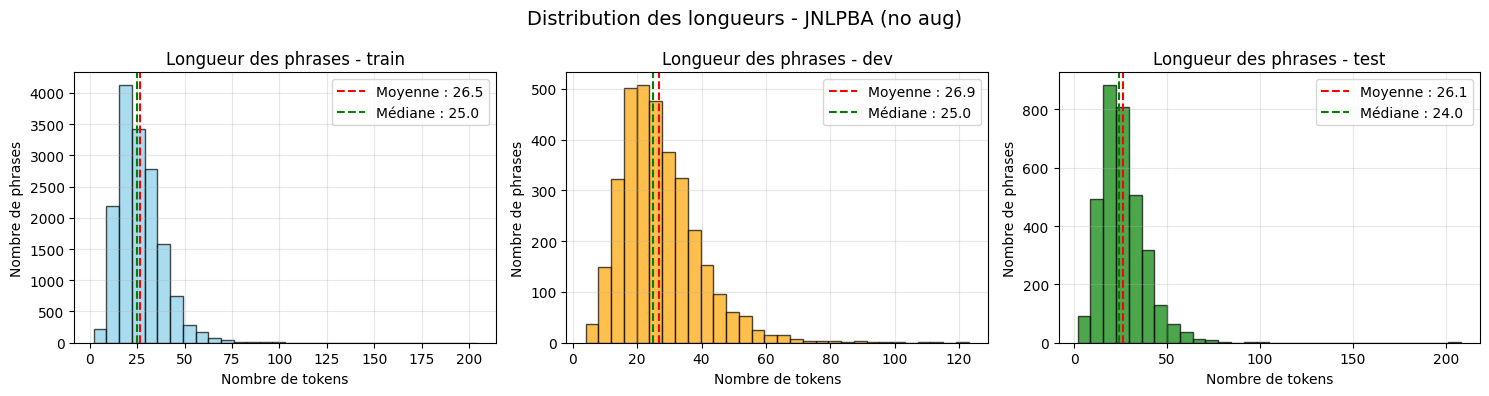


3. DISTRIBUTION DES CLASSES D'ENTITÉS
----------------------------------------

Fréquences absolues :
Classe                    TRAIN        DEV       TEST
-----------------------------------------------------
O                       322,900     70,740     70,970
B-DNA                     7,713      2,019        857
B-RNA                       732        241         96
B-cell_line               3,196        741        393
B-cell_type               5,853      1,056      1,730
B-protein                26,352      4,477      4,507
I-DNA                    12,762      3,404      1,397
I-RNA                     1,106        455        156
I-cell_line               6,234      1,350        792
I-cell_type               7,733      1,315      2,691
I-protein                20,849      4,551      4,222

Pourcentages (par partition) :
Classe                    TRAIN        DEV       TEST
-----------------------------------------------------
O                         77.7%      78.3%      80.8%
B

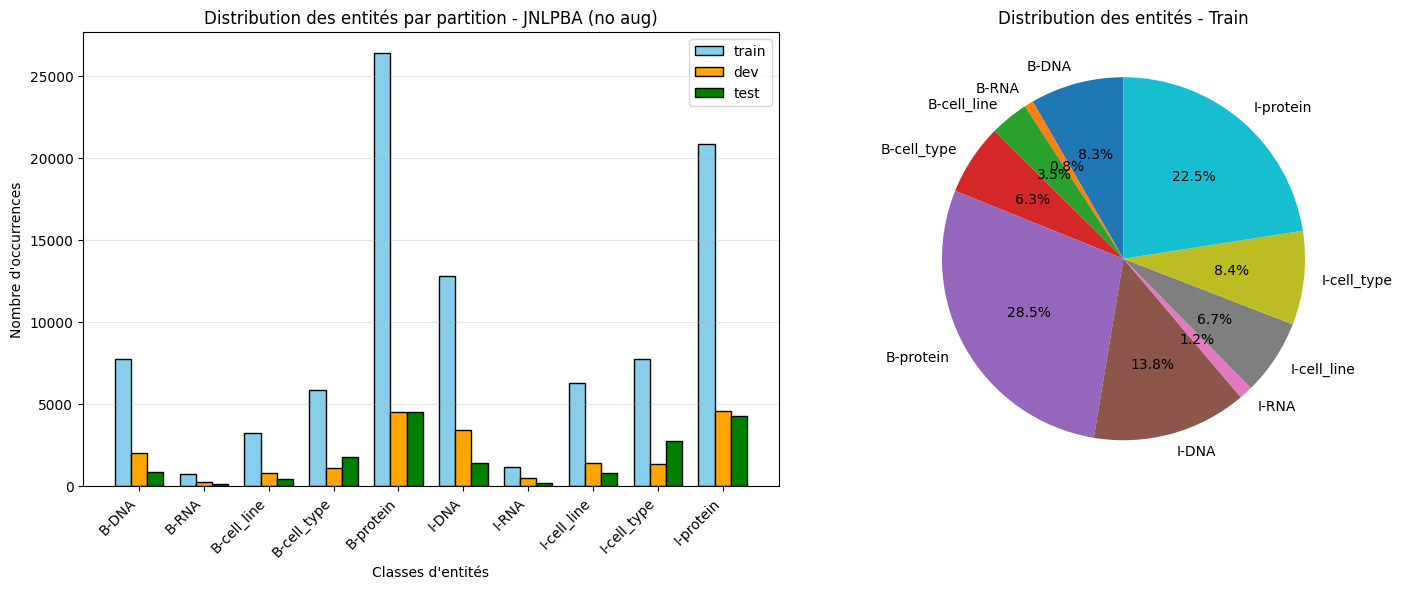


5. ENTITÉS PAR PHRASE
----------------------------------------

TRAIN:
  Entités/phrase (moy) : 5.90
  Entités/phrase (méd) : 5.0
  Phrases sans entité : 1,553 (9.9%)

DEV:
  Entités/phrase (moy) : 5.84
  Entités/phrase (méd) : 5.0
  Phrases sans entité : 412 (12.3%)

TEST:
  Entités/phrase (moy) : 5.01
  Entités/phrase (méd) : 4.0
  Phrases sans entité : 571 (17.0%)


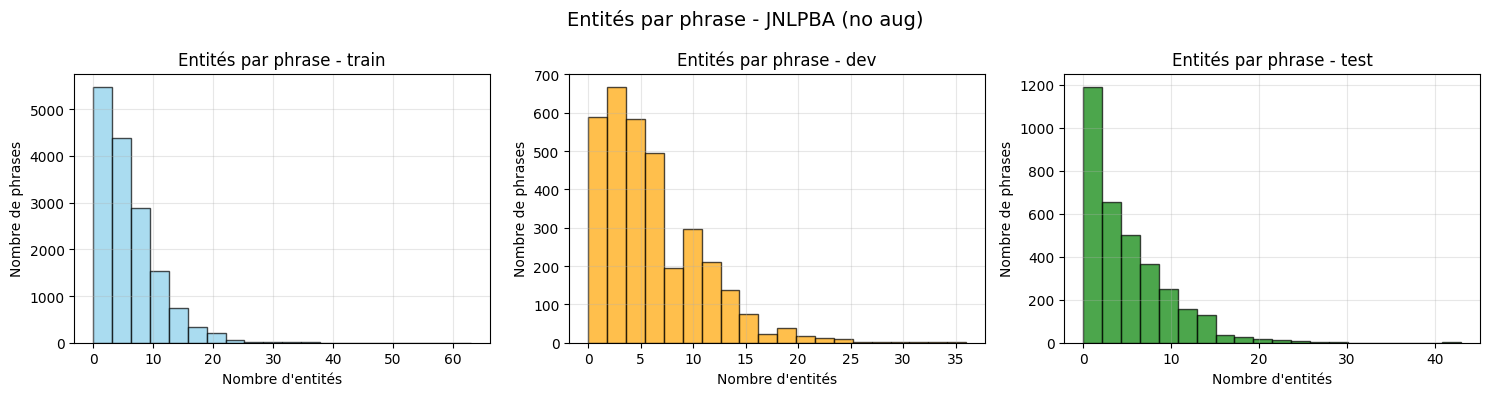


6. ANALYSE DES TAGS BIO
----------------------------------------
Total des tags : 593,590
  B: 59,963 (10.1%)
  I: 69,017 (11.6%)
  O: 464,610 (78.3%)
  autres: 0 (0.0%)

7. INFORMATIONS SUPPLÉMENTAIRES
----------------------------------------
Vocabulaire : 12,664 mots
Classes : ['<PAD>', 'B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']

ANALYSE TERMINÉE
ANALYSE DU DATASET : NCBI (no aug)

1. RÉPARTITION DES DONNÉES
----------------------------------------
Format détecté : NCBI

TRAIN:
  Phrases : 555
  Tokens : 123,206
  Entités nommées : 31,411
  Densité d'entités : 25.5%

DEV:
  Phrases : 118
  Tokens : 21,574
  Entités nommées : 5,891
  Densité d'entités : 27.3%

TEST:
  Phrases : 120
  Tokens : 25,267
  Entités nommées : 6,201
  Densité d'entités : 24.5%

2. LONGUEUR DES PHRASES
----------------------------------------

TRAIN:
  Moyenne : 222.0 tokens
  Médiane : 218.0 tokens
  Min-Max : 56-512 tokens
 

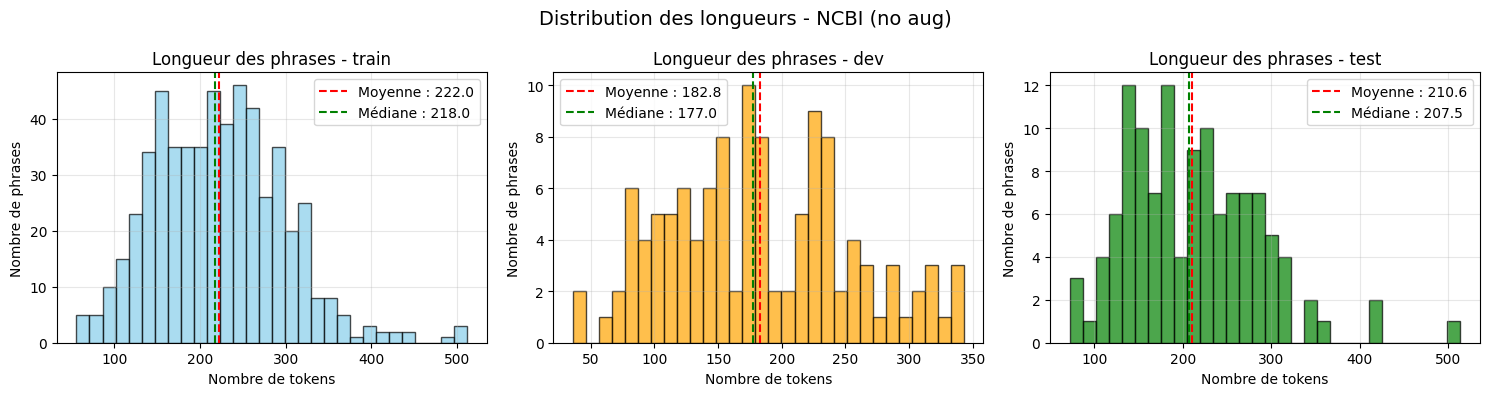


3. DISTRIBUTION DES CLASSES D'ENTITÉS
----------------------------------------

Fréquences absolues :
Classe                    TRAIN        DEV       TEST
-----------------------------------------------------
O                        91,795     15,683     19,066
B-Disease                 4,324        798        821
I-Disease                27,087      5,093      5,380

Pourcentages (par partition) :
Classe                    TRAIN        DEV       TEST
-----------------------------------------------------
O                         74.5%      72.7%      75.5%
B-Disease                  3.5%       3.7%       3.2%
I-Disease                 22.0%      23.6%      21.3%

4. VISUALISATION DES ENTITÉS (sans 'O')


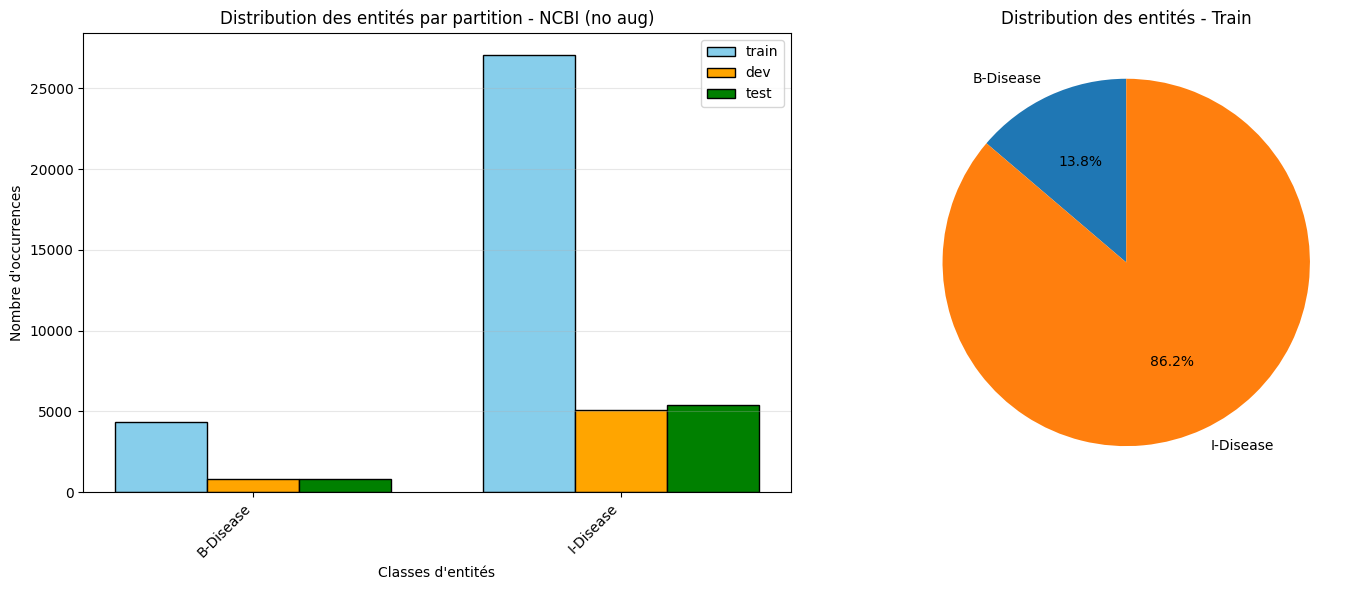


5. ENTITÉS PAR PHRASE
----------------------------------------

TRAIN:
  Entités/phrase (moy) : 56.60
  Entités/phrase (méd) : 49.0
  Phrases sans entité : 1 (0.2%)

DEV:
  Entités/phrase (moy) : 49.92
  Entités/phrase (méd) : 41.5
  Phrases sans entité : 0 (0.0%)

TEST:
  Entités/phrase (moy) : 51.67
  Entités/phrase (méd) : 47.5
  Phrases sans entité : 0 (0.0%)


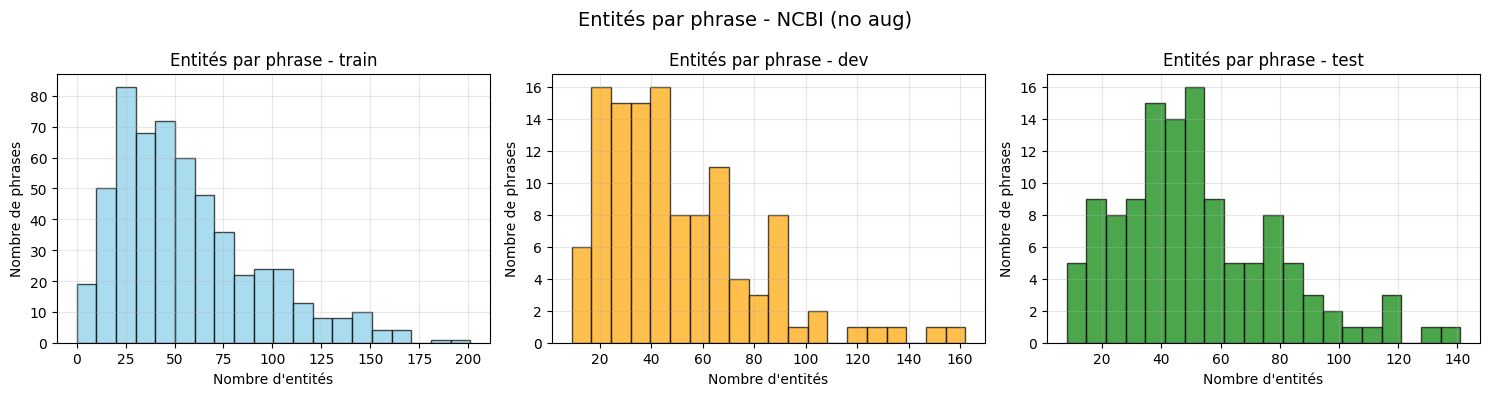


6. ANALYSE DES TAGS BIO
----------------------------------------
Total des tags : 170,047
  B: 5,943 (3.5%)
  I: 37,560 (22.1%)
  O: 126,544 (74.4%)
  autres: 0 (0.0%)

7. INFORMATIONS SUPPLÉMENTAIRES
----------------------------------------
Vocabulaire : 5,747 mots
Classes : ['<PAD>', 'B-Disease', 'I-Disease', 'O']

ANALYSE TERMINÉE


In [8]:
visualize_dataset_distribution_ncbi(results_jnlpba, dataset_name="JNLPBA (no aug)")
visualize_dataset_distribution_ncbi(results_ncbi, dataset_name="NCBI (no aug)")

## ÉTAPE 4: Pipeline d'entraînement (sans `DataAug`)

In [9]:
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch in tqdm(dataloader, desc="Training", leave=False):
        word_ids, char_seqs, tag_ids, lengths = batch
        word_ids = word_ids.to(device)
        char_seqs = char_seqs.to(device)
        tag_ids = tag_ids.to(device)
        mask = (word_ids != 0)

        optimizer.zero_grad()
        loss = model(word_ids, char_seqs, mask, tag_ids)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device, idx_to_tag):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            word_ids, char_seqs, tag_ids, lengths = batch
            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)
            mask = (word_ids != 0)

            loss = model(word_ids, char_seqs, mask, tag_ids)
            total_loss += loss.item()

            predictions = model(word_ids, char_seqs, mask, tags=None)
            for preds_seq, tag_seq, seq_len in zip(predictions, tag_ids, lengths):
                pred_tags = [idx_to_tag.get(idx, 'O') for idx in preds_seq[:seq_len]]
                target_tags = [idx_to_tag.get(idx.item(), 'O') for idx in tag_seq[:seq_len]]
                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)
    return total_loss / len(dataloader), all_predictions, all_targets

def calculate_metrics(predictions, targets):
    from sklearn.metrics import precision_recall_fscore_support
    entity_preds = [p for p, t in zip(predictions, targets) if t != 'O' or p != 'O']
    entity_targets = [t for p, t in zip(predictions, targets) if t != 'O' or p != 'O']
    if not entity_targets:
        return 0.0, 0.0, 0.0
    precision, recall, f1, _ = precision_recall_fscore_support(
        entity_targets, entity_preds, average='macro', zero_division=0
    )
    return precision, recall, f1

In [10]:
def run_pipeline(
    dataset_name: str,
    loaders: dict,
    use_char_cnn: bool = False,
    use_char_lstm: bool = False,
    use_attention: bool = False,
    use_fc_fusion: bool = False,
    lstm_hidden_dim: Optional[int] = None,
    epochs: int = 5,
    patience: int = 3,
    checkpoints_dir: str = "./checkpoints"
):
    train_loader = loaders['train_loader']
    dev_loader = loaders['dev_loader']
    test_loader = loaders['test_loader']
    vocab = loaders['vocab']
    char_vocab = loaders['char_vocab']
    tag_to_idx = loaders['tag_to_idx']
    idx_to_tag = loaders['idx_to_tag']

    # Checkpoint path
    checkpoints_path = f"{checkpoints_dir}/bioMedModel_fullyConnectedAttention_{dataset_name}.pt"
    os.makedirs(checkpoints_dir, exist_ok=True)

    # Embeddings
    pretrained_embeddings = loaders['pretrained_embeddings']

    # Device et model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if lstm_hidden_dim is None:
        lstm_hidden_dim = 256 if dataset_name == 'JNLPBA' else 128

    model = CombinatorialNER(
        vocab_size=len(vocab),
        char_vocab_size=len(char_vocab),
        tag_to_idx=tag_to_idx,
        dataset=dataset_name,
        use_char_cnn=use_char_cnn,
        use_char_lstm=use_char_lstm,
        use_attention=use_attention,
        use_fc_fusion=use_fc_fusion,
        pretrained_embeddings=pretrained_embeddings,
        word_embed_dim=200,
        lstm_hidden_dim=lstm_hidden_dim,
        dropout=0.5
    ).to(device)

    print(f"Intialized {dataset_name} model with {sum(p.numel() for p in model.parameters()):,} params")

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    decay_rate = 0.90 if dataset_name == 'JNLPBA' else 0.95

    best_f1 = 0.0
    patience_counter = 0
    history = {'train_loss': [], 'dev_loss': [], 'dev_f1': [], 'dev_precision': [], 'dev_recall': [], 'lr': []}

    for epoch in range(epochs):
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, device)

        # Eval
        dev_loss, dev_preds, dev_targets = evaluate(model, dev_loader, device, idx_to_tag)
        precision, recall, f1 = calculate_metrics(dev_preds, dev_targets)

        # Decay LR
        for g in optimizer.param_groups:
            g['lr'] *= decay_rate

        # Log
        history['train_loss'].append(train_loss)
        history['dev_loss'].append(dev_loss)
        history['dev_f1'].append(f1)
        history['dev_precision'].append(precision)
        history['dev_recall'].append(recall)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        print(f"Epoch {epoch+1:02d}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Dev Loss: {dev_loss:.4f} | "
              f"F1: {f1:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_f1': best_f1,
            }, checkpoints_path)
            print(f"Meilleur modèle sauvegardé (F1: {f1:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹ Early stopping")
                break

    # Load best et test
    checkpoint = torch.load(checkpoints_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    test_loss, test_preds, test_targets = evaluate(model, test_loader, device, idx_to_tag)
    precision, recall, f1 = calculate_metrics(test_preds, test_targets)

    print("\n" + "="*50)
    print(f"✅ RÉSULTATS FINAUX ({dataset_name})")
    print("="*50)
    print(f"Test F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print("="*50)

    return model, history

## Entraînement JNLPBA

In [11]:
model_jnlpba, history_jnlpba = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    epochs=40,
    patience=4,
    checkpoints_dir="./checkpoints/JNLPBA"
)

Intialized JNLPBA model with 3,030,096 params


Epoch 01/40 | Train Loss: 59.1330 | Dev Loss: 32.6094 | F1: 0.6885 | LR: 0.000900
Meilleur modèle sauvegardé (F1: 0.6885)


Epoch 02/40 | Train Loss: 29.5256 | Dev Loss: 26.2504 | F1: 0.7209 | LR: 0.000810
Meilleur modèle sauvegardé (F1: 0.7209)


Epoch 03/40 | Train Loss: 24.2360 | Dev Loss: 24.7011 | F1: 0.7149 | LR: 0.000729


Epoch 04/40 | Train Loss: 21.6120 | Dev Loss: 22.1024 | F1: 0.7217 | LR: 0.000656
Meilleur modèle sauvegardé (F1: 0.7217)


Epoch 05/40 | Train Loss: 19.7295 | Dev Loss: 21.2302 | F1: 0.7306 | LR: 0.000590
Meilleur modèle sauvegardé (F1: 0.7306)


Epoch 06/40 | Train Loss: 18.5297 | Dev Loss: 20.9923 | F1: 0.7377 | LR: 0.000531
Meilleur modèle sauvegardé (F1: 0.7377)


Epoch 07/40 | Train Loss: 17.9713 | Dev Loss: 20.7466 | F1: 0.7393 | LR: 0.000478
Meilleur modèle sauvegardé (F1: 0.7393)


Epoch 08/40 | Train Loss: 16.9252 | Dev Loss: 19.9189 | F1: 0.7399 | LR: 0.000430
Meilleur modèle sauvegardé (F1: 0.7399)


Epoch 09/40 | Train Loss: 16.2915 | Dev Loss: 19.8964 | F1: 0.7364 | LR: 0.000387


Epoch 10/40 | Train Loss: 15.7640 | Dev Loss: 19.6622 | F1: 0.7443 | LR: 0.000349
Meilleur modèle sauvegardé (F1: 0.7443)


Epoch 11/40 | Train Loss: 15.2894 | Dev Loss: 19.6702 | F1: 0.7443 | LR: 0.000314


Epoch 12/40 | Train Loss: 14.8161 | Dev Loss: 19.4089 | F1: 0.7442 | LR: 0.000282


Epoch 13/40 | Train Loss: 14.3909 | Dev Loss: 19.3785 | F1: 0.7449 | LR: 0.000254
Meilleur modèle sauvegardé (F1: 0.7449)


Epoch 14/40 | Train Loss: 14.0708 | Dev Loss: 19.2694 | F1: 0.7491 | LR: 0.000229
Meilleur modèle sauvegardé (F1: 0.7491)


Epoch 15/40 | Train Loss: 13.7350 | Dev Loss: 19.3453 | F1: 0.7453 | LR: 0.000206


Epoch 16/40 | Train Loss: 13.4351 | Dev Loss: 19.6088 | F1: 0.7487 | LR: 0.000185


Epoch 17/40 | Train Loss: 13.1984 | Dev Loss: 19.3236 | F1: 0.7471 | LR: 0.000167


Epoch 18/40 | Train Loss: 12.9914 | Dev Loss: 19.2532 | F1: 0.7507 | LR: 0.000150
Meilleur modèle sauvegardé (F1: 0.7507)


Epoch 19/40 | Train Loss: 12.7050 | Dev Loss: 19.4290 | F1: 0.7456 | LR: 0.000135


Epoch 20/40 | Train Loss: 12.4248 | Dev Loss: 19.6342 | F1: 0.7488 | LR: 0.000122


Epoch 21/40 | Train Loss: 12.3303 | Dev Loss: 19.5000 | F1: 0.7460 | LR: 0.000109


Epoch 22/40 | Train Loss: 12.1471 | Dev Loss: 19.5365 | F1: 0.7497 | LR: 0.000098
⏹ Early stopping


C:\Users\oumak\AppData\Local\Temp\ipykernel_19008\3149230694.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoints_path, map_location=devi


✅ RÉSULTATS FINAUX (JNLPBA)
Test F1: 0.6950 | Precision: 0.6727 | Recall: 0.7283


## Entraînement NCBI

In [12]:
model_ncbi, history_ncbi = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    epochs=40,
    patience=5,
    checkpoints_dir="./checkpoints/NCBI"
)

Intialized NCBI model with 1,430,068 params


Training:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 01/40 | Train Loss: 968.7920 | Dev Loss: 735.3218 | F1: 0.0466 | LR: 0.000950
Meilleur modèle sauvegardé (F1: 0.0466)


Epoch 02/40 | Train Loss: 640.5198 | Dev Loss: 521.8911 | F1: 0.2820 | LR: 0.000902
Meilleur modèle sauvegardé (F1: 0.2820)


Epoch 03/40 | Train Loss: 430.4631 | Dev Loss: 353.4021 | F1: 0.4175 | LR: 0.000857
Meilleur modèle sauvegardé (F1: 0.4175)


Epoch 04/40 | Train Loss: 363.4208 | Dev Loss: 316.5143 | F1: 0.4461 | LR: 0.000815
Meilleur modèle sauvegardé (F1: 0.4461)


Epoch 05/40 | Train Loss: 313.6460 | Dev Loss: 306.8165 | F1: 0.4552 | LR: 0.000774
Meilleur modèle sauvegardé (F1: 0.4552)


Epoch 06/40 | Train Loss: 281.4455 | Dev Loss: 257.3072 | F1: 0.4928 | LR: 0.000735
Meilleur modèle sauvegardé (F1: 0.4928)


Epoch 07/40 | Train Loss: 253.0341 | Dev Loss: 233.1533 | F1: 0.5190 | LR: 0.000698
Meilleur modèle sauvegardé (F1: 0.5190)


Epoch 08/40 | Train Loss: 240.7578 | Dev Loss: 219.4925 | F1: 0.5344 | LR: 0.000663
Meilleur modèle sauvegardé (F1: 0.5344)


Epoch 09/40 | Train Loss: 222.4346 | Dev Loss: 211.3482 | F1: 0.5374 | LR: 0.000630
Meilleur modèle sauvegardé (F1: 0.5374)


Epoch 10/40 | Train Loss: 203.0918 | Dev Loss: 206.5248 | F1: 0.5495 | LR: 0.000599
Meilleur modèle sauvegardé (F1: 0.5495)


Epoch 11/40 | Train Loss: 189.3315 | Dev Loss: 191.7393 | F1: 0.5527 | LR: 0.000569
Meilleur modèle sauvegardé (F1: 0.5527)


Epoch 12/40 | Train Loss: 176.3192 | Dev Loss: 184.0365 | F1: 0.5545 | LR: 0.000540
Meilleur modèle sauvegardé (F1: 0.5545)


Epoch 13/40 | Train Loss: 166.3388 | Dev Loss: 168.1787 | F1: 0.5613 | LR: 0.000513
Meilleur modèle sauvegardé (F1: 0.5613)


Epoch 14/40 | Train Loss: 159.1180 | Dev Loss: 166.0424 | F1: 0.5636 | LR: 0.000488
Meilleur modèle sauvegardé (F1: 0.5636)


Epoch 15/40 | Train Loss: 149.2241 | Dev Loss: 160.7701 | F1: 0.5668 | LR: 0.000463
Meilleur modèle sauvegardé (F1: 0.5668)


Epoch 16/40 | Train Loss: 144.1192 | Dev Loss: 161.9782 | F1: 0.5666 | LR: 0.000440


Epoch 17/40 | Train Loss: 141.1481 | Dev Loss: 159.6073 | F1: 0.5653 | LR: 0.000418


Epoch 18/40 | Train Loss: 135.4959 | Dev Loss: 159.9783 | F1: 0.5708 | LR: 0.000397
Meilleur modèle sauvegardé (F1: 0.5708)


Epoch 19/40 | Train Loss: 130.6793 | Dev Loss: 147.0317 | F1: 0.5739 | LR: 0.000377
Meilleur modèle sauvegardé (F1: 0.5739)


Epoch 20/40 | Train Loss: 126.1579 | Dev Loss: 152.3104 | F1: 0.5748 | LR: 0.000358
Meilleur modèle sauvegardé (F1: 0.5748)


Epoch 21/40 | Train Loss: 122.5026 | Dev Loss: 144.1704 | F1: 0.5804 | LR: 0.000341
Meilleur modèle sauvegardé (F1: 0.5804)


Epoch 22/40 | Train Loss: 117.0935 | Dev Loss: 139.3990 | F1: 0.5839 | LR: 0.000324
Meilleur modèle sauvegardé (F1: 0.5839)


Epoch 23/40 | Train Loss: 116.3720 | Dev Loss: 138.4773 | F1: 0.5815 | LR: 0.000307


Epoch 24/40 | Train Loss: 116.6454 | Dev Loss: 139.9996 | F1: 0.5777 | LR: 0.000292


Epoch 25/40 | Train Loss: 107.7536 | Dev Loss: 141.1060 | F1: 0.5831 | LR: 0.000277


Epoch 26/40 | Train Loss: 111.9820 | Dev Loss: 136.4043 | F1: 0.5846 | LR: 0.000264
Meilleur modèle sauvegardé (F1: 0.5846)


Epoch 27/40 | Train Loss: 106.9644 | Dev Loss: 137.0146 | F1: 0.5828 | LR: 0.000250


Epoch 28/40 | Train Loss: 104.2036 | Dev Loss: 129.5428 | F1: 0.5875 | LR: 0.000238
Meilleur modèle sauvegardé (F1: 0.5875)


Epoch 29/40 | Train Loss: 101.5418 | Dev Loss: 133.0867 | F1: 0.5902 | LR: 0.000226
Meilleur modèle sauvegardé (F1: 0.5902)


Epoch 30/40 | Train Loss: 99.7336 | Dev Loss: 128.4068 | F1: 0.5911 | LR: 0.000215
Meilleur modèle sauvegardé (F1: 0.5911)


Epoch 31/40 | Train Loss: 100.2362 | Dev Loss: 128.2745 | F1: 0.5923 | LR: 0.000204
Meilleur modèle sauvegardé (F1: 0.5923)


Epoch 32/40 | Train Loss: 98.0084 | Dev Loss: 134.5773 | F1: 0.5889 | LR: 0.000194


Epoch 33/40 | Train Loss: 94.8788 | Dev Loss: 127.2830 | F1: 0.5926 | LR: 0.000184
Meilleur modèle sauvegardé (F1: 0.5926)


Epoch 34/40 | Train Loss: 94.4198 | Dev Loss: 128.1885 | F1: 0.5919 | LR: 0.000175


Epoch 35/40 | Train Loss: 94.9060 | Dev Loss: 126.3271 | F1: 0.5923 | LR: 0.000166


Epoch 36/40 | Train Loss: 92.7669 | Dev Loss: 128.0468 | F1: 0.5929 | LR: 0.000158
Meilleur modèle sauvegardé (F1: 0.5929)


Epoch 37/40 | Train Loss: 91.0530 | Dev Loss: 127.1152 | F1: 0.5926 | LR: 0.000150


Epoch 38/40 | Train Loss: 88.9682 | Dev Loss: 124.5963 | F1: 0.5949 | LR: 0.000142
Meilleur modèle sauvegardé (F1: 0.5949)


Epoch 39/40 | Train Loss: 85.8723 | Dev Loss: 127.9415 | F1: 0.5939 | LR: 0.000135


Epoch 40/40 | Train Loss: 88.1257 | Dev Loss: 123.9116 | F1: 0.5926 | LR: 0.000129


C:\Users\oumak\AppData\Local\Temp\ipykernel_19008\3149230694.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoints_path, map_location=devi


✅ RÉSULTATS FINAUX (NCBI)
Test F1: 0.5901 | Precision: 0.5711 | Recall: 0.6106


## Visualisation (optionnelle)

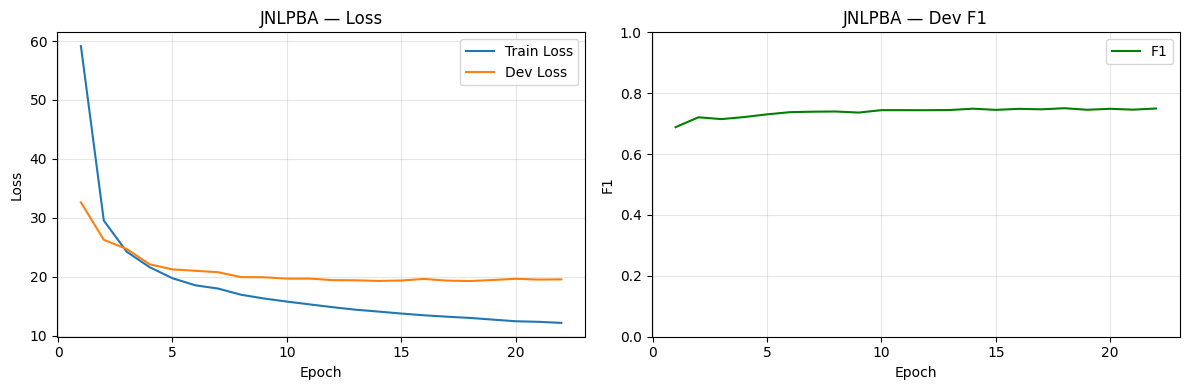

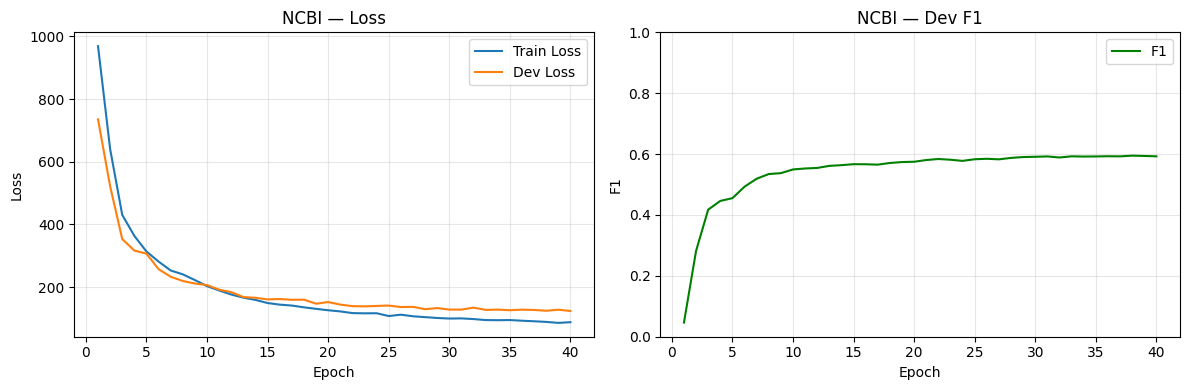

In [13]:
def plot_training_history(history, dataset_name):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['dev_loss'], label='Dev Loss')
    plt.title(f'{dataset_name} — Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['dev_f1'], label='F1', color='green')
    plt.title(f'{dataset_name} — Dev F1')
    plt.xlabel('Epoch'); plt.ylabel('F1'); plt.ylim(0, 1); plt.legend(); plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_training_history(history_jnlpba, "JNLPBA")
plot_training_history(history_ncbi, "NCBI")

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

In [15]:
def evaluate_and_get_metrics(model, dataloader, device, idx_to_tag, dataset_name="Dataset"):
    """
    Run full evaluation and return detailed metrics + predictions
    """
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            word_ids, char_seqs, tag_ids, lengths = batch
            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)
            mask = (word_ids != 0)

            # Get predictions
            predictions = model(word_ids, char_seqs, mask, tags=None)
            
            # Convert to tag strings
            for preds_seq, tag_seq, seq_len in zip(predictions, tag_ids, lengths):
                pred_tags = [idx_to_tag.get(idx, 'O') for idx in preds_seq[:seq_len]]
                target_tags = [idx_to_tag.get(idx.item(), 'O') for idx in tag_seq[:seq_len]]
                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)

    # Filter out 'O' for entity-level metrics (but keep for confusion matrix)
    entity_indices = [i for i, t in enumerate(all_targets) if t != 'O' or all_predictions[i] != 'O']
    entity_preds = [all_predictions[i] for i in entity_indices]
    entity_targets = [all_targets[i] for i in entity_indices]

    return {
        'predictions': all_predictions,
        'targets': all_targets,
        'entity_predictions': entity_preds,
        'entity_targets': entity_targets
    }

In [16]:
def plot_confusion_matrix_by_class(
    predictions, 
    targets, 
    idx_to_tag, 
    dataset_name="Dataset",
    figsize=(14, 6)
):
    """
    Affiche DEUX matrices de confusion + rapports complets :
    • Haut : TOUS les tokens (incluant 'O')
    • Bas  : ENTITÉS SEULEMENT (excluant 'O')
    
    Returns:
        dict: {
            'with_O': {'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'f1_weighted'},
            'without_O': {same},
            'per_class_with_O': {...},
            'per_class_without_O': {...}
        }
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (
        confusion_matrix, classification_report, 
        precision_recall_fscore_support, accuracy_score
    )

    # --- Preprocess ---
    predictions = [str(p) for p in predictions]
    targets = [str(t) for t in targets]

    # Get all unique labels (sorted)
    all_labels = sorted(set(targets + predictions))
    entity_labels = [l for l in all_labels if l != 'O']

    print(f"\n📊 ÉVALUATION NER — {dataset_name}")
    print("=" * 60)
    print(f"✓ Tokens totaux         : {len(targets):,}")
    print(f"✓ Tokens entités (non-O): {len([t for t in targets if t != 'O']):,}")

    results = {}

    # ─────────────────────────────────────────────
    # 1. WITH 'O' (all tokens)
    # ─────────────────────────────────────────────
    print("\n" + "─" * 50)
    print("✅ ÉVALUATION AVEC 'O' (tous les tokens)")
    print("─" * 50)

    acc_all = accuracy_score(targets, predictions)
    precision_macro_all, recall_macro_all, f1_macro_all, _ = precision_recall_fscore_support(
        targets, predictions, average='macro', zero_division=0
    )
    precision_weighted_all, recall_weighted_all, f1_weighted_all, _ = precision_recall_fscore_support(
        targets, predictions, average='weighted', zero_division=0
    )

    print(f"  Accuracy (tous tokens)    : {acc_all:.4f}")
    print(f"  F1 Macro                 : {f1_macro_all:.4f}")
    print(f"  F1 Weighted              : {f1_weighted_all:.4f}")

    # Confusion matrix (with 'O')
    cm_all = confusion_matrix(targets, predictions, labels=all_labels)
    cm_norm_all = cm_all.astype('float') / cm_all.sum(axis=1, keepdims=True)
    cm_norm_all = np.nan_to_num(cm_norm_all)

    # Classification report
    report_all = classification_report(targets, predictions, zero_division=0, output_dict=True)
    per_class_with_O = {
        label: {
            'precision': report_all[label]['precision'],
            'recall': report_all[label]['recall'],
            'f1': report_all[label]['f1-score'],
            'support': int(report_all[label]['support'])
        }
        for label in all_labels if label in report_all and 'support' in report_all[label]
    }

    results['with_O'] = {
        'accuracy': acc_all,
        'precision_macro': precision_macro_all,
        'recall_macro': recall_macro_all,
        'f1_macro': f1_macro_all,
        'f1_weighted': f1_weighted_all
    }
    results['per_class_with_O'] = per_class_with_O

    # ─────────────────────────────────────────────
    # 2. WITHOUT 'O' (entities only)
    # ─────────────────────────────────────────────
    print("\n" + "─" * 50)
    print("✅ ÉVALUATION SANS 'O' (entités uniquement)")
    print("─" * 50)

    entity_mask = [t != 'O' for t in targets]
    entity_preds = [p for p, m in zip(predictions, entity_mask) if m]
    entity_targets = [t for t, m in zip(targets, entity_mask) if m]

    if entity_targets:
        acc_entities = accuracy_score(entity_targets, entity_preds)
        precision_macro_ent, recall_macro_ent, f1_macro_ent, _ = precision_recall_fscore_support(
            entity_targets, entity_preds, average='macro', zero_division=0
        )
        precision_weighted_ent, recall_weighted_ent, f1_weighted_ent, _ = precision_recall_fscore_support(
            entity_targets, entity_preds, average='weighted', zero_division=0
        )

        print(f"  Accuracy (tokens entités) : {acc_entities:.4f}")
        print(f"  F1 Macro                  : {f1_macro_ent:.4f}")
        print(f"  F1 Weighted               : {f1_weighted_ent:.4f}")
    else:
        acc_entities = precision_macro_ent = recall_macro_ent = f1_macro_ent = f1_weighted_ent = 0.0
        print("  ⚠️ Aucune entité trouvée.")

    # Confusion matrix (without 'O')
    cm_ent = confusion_matrix(entity_targets, entity_preds, labels=entity_labels) if entity_labels else np.array([[0]])
    cm_norm_ent = cm_ent.astype('float') / cm_ent.sum(axis=1, keepdims=True) if cm_ent.size else cm_ent
    cm_norm_ent = np.nan_to_num(cm_norm_ent)

    # Classification report (entities only)
    per_class_without_O = {}
    if entity_labels and entity_targets:
        report_ent = classification_report(entity_targets, entity_preds, labels=entity_labels, zero_division=0, output_dict=True)
        per_class_without_O = {
            label: {
                'precision': report_ent[label]['precision'],
                'recall': report_ent[label]['recall'],
                'f1': report_ent[label]['f1-score'],
                'support': int(report_ent[label]['support'])
            }
            for label in entity_labels if label in report_ent and 'support' in report_ent[label]
        }

    results['without_O'] = {
        'accuracy': acc_entities,
        'precision_macro': precision_macro_ent,
        'recall_macro': recall_macro_ent,
        'f1_macro': f1_macro_ent,
        'f1_weighted': f1_weighted_ent
    }
    results['per_class_without_O'] = per_class_without_O

    # ─────────────────────────────────────────────
    # 3. PLOTS (Side-by-side)
    # ─────────────────────────────────────────────
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # --- Left: WITH 'O' ---
    sns.heatmap(
        cm_norm_all, annot=True, fmt='.2f', cmap='Blues',
        xticklabels=all_labels, yticklabels=all_labels,
        ax=axes[0], cbar_kws={'label': 'Proportion'}
    )
    axes[0].set_title(f"Tous les tokens (incluant 'O')\nAcc: {acc_all:.3f} | F1 (macro): {f1_macro_all:.3f}")
    axes[0].set_xlabel('Prédictions')
    axes[0].set_ylabel('Vérité')

    # --- Right: WITHOUT 'O' ---
    if entity_labels:
        sns.heatmap(
            cm_norm_ent, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=entity_labels, yticklabels=entity_labels,
            ax=axes[1], cbar_kws={'label': 'Proportion'}
        )
        axes[1].set_title(f"Entités uniquement (sans 'O')\nAcc: {acc_entities:.3f} | F1 (macro): {f1_macro_ent:.3f}")
        axes[1].set_xlabel('Prédictions')
        axes[1].set_ylabel('Vérité')
    else:
        axes[1].text(0.5, 0.5, 'Aucune entité', ha='center', va='center', fontsize=14)
        axes[1].set_title("Entités uniquement (sans 'O')")

    plt.suptitle(f"Matrices de confusion — {dataset_name}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    
def print_metrics(targets, predictions, dataset_name="Dataset", include_entity_only=False):
    """Print global and per-class metrics"""
    print("="*70)
    print(f"METRICS FOR {dataset_name.upper()}")
    print("="*70)
    
    # Global metrics (including 'O')
    if not include_entity_only:
        print("\nGLOBAL METRICS (including 'O'):")
        print(classification_report(targets, predictions, zero_division=0))
    
    # Entity-only metrics (excluding 'O')
    entity_mask = [t != 'O' or p != 'O' for t, p in zip(targets, predictions)]
    entity_targets = [t for t, m in zip(targets, entity_mask) if m]
    entity_preds = [p for p, m in zip(predictions, entity_mask) if m]
    
    print("\nENTITY-LEVEL METRICS (excluding 'O'):")
    report = classification_report(entity_targets, entity_preds, zero_division=0)
    print(report)
    
    # Macro/Weighted averages
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        entity_targets, entity_preds, average='macro', zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        entity_targets, entity_preds, average='weighted', zero_division=0
    )
    
    print("\n📊 SUMMARY (Entity-Level):")
    print(f"  Macro F1:    {f1_macro:.4f}")
    print(f"  Weighted F1: {f1_weighted:.4f}")
    print(f"  Macro Precision: {precision_macro:.4f}")
    print(f"  Macro Recall:    {recall_macro:.4f}")

In [17]:
# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Evaluate JNLPBA
print("Evaluating JNLPBA...")
jnlpba_results = evaluate_and_get_metrics(
    model_jnlpba, results_jnlpba['test_loader'], device, results_jnlpba['idx_to_tag'], "JNLPBA"
)

# Evaluate NCBI
print("Evaluating NCBI...")
ncbi_results = evaluate_and_get_metrics(
    model_ncbi, results_ncbi['test_loader'], device, results_ncbi['idx_to_tag'], "NCBI"
)

# Print metrics
print_metrics(jnlpba_results['targets'], jnlpba_results['predictions'], "JNLPBA")
print_metrics(ncbi_results['targets'], ncbi_results['predictions'], "NCBI")

Evaluating JNLPBA...
Evaluating NCBI...
METRICS FOR JNLPBA

GLOBAL METRICS (including 'O'):
              precision    recall  f1-score   support

       B-DNA       0.73      0.71      0.72       857
       B-RNA       0.73      0.82      0.77        96
 B-cell_line       0.55      0.70      0.61       393
 B-cell_type       0.85      0.72      0.78      1730
   B-protein       0.74      0.88      0.81      4507
       I-DNA       0.80      0.86      0.83      1397
       I-RNA       0.76      0.94      0.84       156
 I-cell_line       0.54      0.79      0.65       792
 I-cell_type       0.88      0.77      0.82      2691
   I-protein       0.81      0.81      0.81      4222
           O       0.98      0.97      0.97     70962

    accuracy                           0.94     87803
   macro avg       0.76      0.82      0.78     87803
weighted avg       0.94      0.94      0.94     87803


ENTITY-LEVEL METRICS (excluding 'O'):
              precision    recall  f1-score   support

 

In [18]:
import torch

# ─────────────────────────────────────────────
# 1. Chargement checkpoint
# ─────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint_path = "./checkpoints/NCBI/bioMedModel_fullyConnectedAttention_NCBI.pt"
ckpt = torch.load(checkpoint_path, map_location=device)

# ─────────────────────────────────────────────
# 2. Récupération EXACTE des objets du training
# ─────────────────────────────────────────────
# Ces objets doivent venir des loaders utilisés à l'entraînement
train_loader = results_ncbi["train_loader"]
vocab        = results_ncbi["vocab"]
char_vocab   = results_ncbi["char_vocab"]
tag_to_idx   = results_ncbi["tag_to_idx"]
idx_to_tag   = results_ncbi["idx_to_tag"]

# ─────────────────────────────────────────────
# 3. Reconstruction du modèle (IDENTIQUE au training)
# ─────────────────────────────────────────────
model = CombinatorialNER(
    dataset="NCBI",
    vocab_size=len(vocab),
    char_vocab_size=len(char_vocab),
    tag_to_idx=tag_to_idx,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    pretrained_embeddings=results_ncbi["pretrained_embeddings"],
    word_embed_dim=200,
    lstm_hidden_dim=128,   # JNLPBA
    dropout=0.5
).to(device)

model.load_state_dict(ckpt["model_state_dict"])
model.eval()

def token_accuracy(all_preds, all_golds):
    correct = 0
    total = 0
    for preds, golds in zip(all_preds, all_golds):
        for p, g in zip(preds, golds):
            if g != "<PAD>":
                total += 1
                if p == g:
                    correct += 1
    return correct / total

def token_accuracy_single(preds, golds):
    correct = 0
    total = 0
    for p, g in zip(preds, golds):
        if g != "<PAD>":
            total += 1
            if p == g:
                correct += 1
    return correct / total if total > 0 else 0.0


# ─────────────────────────────────────────────
# 4. Fonction de prédiction CORRECTE
# ─────────────────────────────────────────────
def predict_sentence(
    model,
    sentence,
    vocab,
    char_vocab,
    idx_to_tag,
    device,
    max_seq_len=100,
    max_char_len=20
):
    model.eval()

    PAD_WORD = vocab["<PAD>"]
    UNK_WORD = vocab["<UNK>"]
    PAD_CHAR = char_vocab["<PAD>"]
    UNK_CHAR = char_vocab["<UNK>"]

    # 1. Troncature
    tokens = sentence[:max_seq_len]
    seq_len = len(tokens)

    # 2. Word IDs
    word_ids = [vocab.get(w.lower(), UNK_WORD) for w in tokens]
    word_ids += [PAD_WORD] * (max_seq_len - seq_len)

    # 3. Char IDs
    char_seqs = []
    for w in tokens:
        chars = [char_vocab.get(c, UNK_CHAR) for c in w[:max_char_len]]
        chars += [PAD_CHAR] * (max_char_len - len(chars))
        char_seqs.append(chars)

    char_seqs += [[PAD_CHAR] * max_char_len] * (max_seq_len - seq_len)

    # 4. Tensors
    word_tensor = torch.tensor(word_ids).unsqueeze(0).to(device)
    char_tensor = torch.tensor(char_seqs).unsqueeze(0).to(device)

    mask = torch.zeros((1, max_seq_len), dtype=torch.bool).to(device)
    mask[:, :seq_len] = True

    # 5. Inference CRF
    with torch.no_grad():
        predictions = model(word_tensor, char_tensor, mask)
        predicted_ids = predictions[0][:seq_len]

    return [idx_to_tag[i] for i in predicted_ids]



test_data = [
    # Example 1
    (["the", "hereditary", "breast", "and", "ovarian", "cancer", "syndrome", "is", "associated", "with", "a", "high", "frequency", "of", "brca1", "mutations", "."],
     ["O", "B-Disease", "I-Disease", "I-Disease", "I-Disease", "I-Disease", "I-Disease", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O"]),

    # Example 2
    (["patients", "with", "BRCA1", "mutation", "show", "increased", "risk"],
     ["O", "O", "B-Disease", "I-Disease", "O", "O", "O"]),

    # Example 3
    (["the", "prevalence", "of", "hereditary", "breast", "cancer", "is", "high", "in", "certain", "populations"],
     ["O", "O", "O", "B-Disease", "I-Disease", "I-Disease", "O", "O", "O", "O", "O"])
]




# ─────────────────────────────────────────────
# 6. Évaluation lisible
# ─────────────────────────────────────────────
all_preds = []
all_golds = []

for i, (sentence, gold) in enumerate(test_data, 1):
    preds = predict_sentence(model, sentence, vocab, char_vocab, idx_to_tag, device)

    all_preds.append(preds)
    all_golds.append(gold)

    # Accuracy par phrase
    acc_sentence = token_accuracy_single(preds, gold)

    print(f"Example {i}")
    print(f"{'Token':15s} {'Gold':15s} {'Predicted':15s}")
    print("-" * 50)
    for t, g, p in zip(sentence, gold, preds):
        print(f"{t:15s} {g:15s} {p:15s}")

    print(f"\nToken accuracy (sentence): {acc_sentence:.4f}")
    print("=" * 60 + "\n")

# Accuracy globale
acc_global = token_accuracy(all_preds, all_golds)
print(f"Global token accuracy: {acc_global:.4f}")

Example 1
Token           Gold            Predicted      
--------------------------------------------------
the             O               O              
hereditary      B-Disease       B-Disease      
breast          I-Disease       I-Disease      
and             I-Disease       I-Disease      
ovarian         I-Disease       I-Disease      
cancer          I-Disease       I-Disease      
syndrome        I-Disease       I-Disease      
is              O               I-Disease      
associated      O               I-Disease      
with            O               I-Disease      
a               O               I-Disease      
high            O               I-Disease      
frequency       O               I-Disease      
of              O               O              
brca1           O               O              
mutations       O               O              
.               O               O              

Token accuracy (sentence): 0.6471

Example 2
Token           Gold         

C:\Users\oumak\AppData\Local\Temp\ipykernel_19008\1558245796.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


# Detailed evaluation

In [19]:
def load_trained_model(model_path, dataset_name, loaders_dict,use_char_cnn=False,use_char_lstm=False,use_attention=False,use_fc_fusion=False):
    """
    Charge un modèle entraîné et le prépare pour les prédictions
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Récupérer les paramètres du loader
    vocab = loaders_dict['vocab']
    char_vocab = loaders_dict['char_vocab']
    tag_to_idx = loaders_dict['tag_to_idx']
    idx_to_tag = loaders_dict['idx_to_tag']
    
    # Déterminer les paramètres selon le dataset
    if dataset_name == 'JNLPBA':
        lstm_hidden = 256
    else:  # NCBI-Disease
        lstm_hidden = 128
    
    # Créer le modèle
    model = CombinatorialNER(
        dataset=dataset_name,
        vocab_size=len(vocab),
        char_vocab_size=len(char_vocab),
        tag_to_idx=tag_to_idx,
        use_char_cnn=use_char_cnn,       
        use_char_lstm=use_char_lstm,      
        use_attention=use_attention,     
        use_fc_fusion=use_fc_fusion,  
        pretrained_embeddings=None,  
        word_embed_dim=200,
        lstm_hidden_dim=lstm_hidden,
        dropout=0.5
    ).to(device)

    
    # Charger les poids sauvegardés
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Mode évaluation
    
    print(f"Modèle chargé depuis: {model_path}")
    print(f"Best F1 enregistré: {checkpoint.get('best_f1', 'N/A'):.4f}")
    print(f"Époque: {checkpoint.get('epoch', 'N/A')}")
    
    return model, device, idx_to_tag




def predict_on_test_set(model, test_loader, device, idx_to_tag):
    """
    Version simplifiée et robuste
    """
    shown_example = False
    model.eval()
    all_predictions = []
    all_targets = []
    for idx, tag in sorted(idx_to_tag.items()):
        print(f"  {idx} -> {tag}")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            word_ids, char_seqs, tag_ids, lengths = batch
            
            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)
            mask = (word_ids != 0)
            pred_sequences = model(word_ids, char_seqs, mask, tags=None)
            
            for i in range(len(word_ids)):
                actual_len = lengths[i]
                if isinstance(pred_sequences, list):
                    pred_seq = pred_sequences[i][:actual_len]
                else:
                    pred_seq = torch.argmax(pred_sequences[i], dim=1)[:actual_len].cpu().numpy()
                
                # Convertir indices -> tags
                pred_tags = []
                for idx in pred_seq:
                    if isinstance(idx, torch.Tensor):
                        idx = idx.item()
                    tag = idx_to_tag.get(int(idx), 'O')
                    pred_tags.append(tag)
                
                # Convertir cibles indices -> tags
                target_indices = tag_ids[i][:actual_len].cpu().numpy()
                target_tags = [idx_to_tag.get(int(idx), 'O') for idx in target_indices]
                
                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)
                if not shown_example:
                    for pos, (g, p) in enumerate(zip(target_tags, pred_tags)):
                            mark = "correct" if g == p else "incorrect"
                            print(f"{pos:3d} | {g:18s} | {p:18s} {mark}")
                    shown_example=True
    
    return all_predictions, all_targets  


C:\Users\oumak\AppData\Local\Temp\ipykernel_19008\2343084737.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Modèle chargé depuis: ./checkpoints/JNLPBA/bioMedModel_fullyConnectedAttention_JNLPBA.pt
Best F1 enregistré: 0.7507
Époque: 17
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-protein          incorrect
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | 

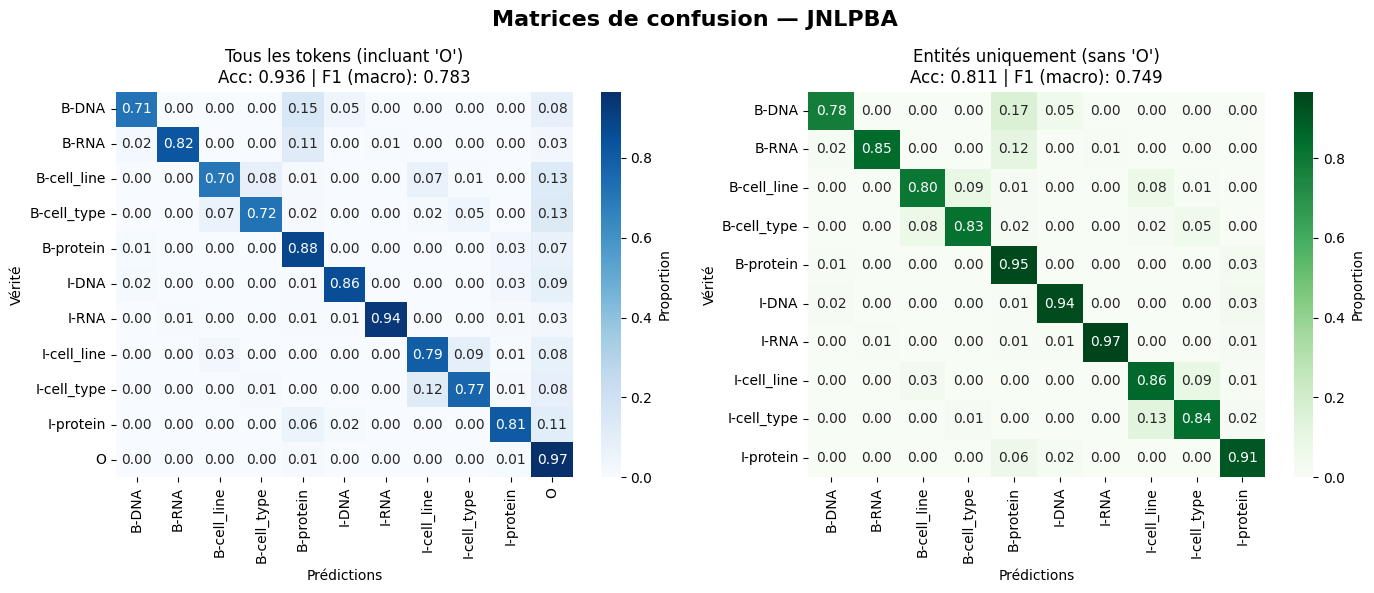

In [20]:
model_path_jnlpba = "./checkpoints/JNLPBA/bioMedModel_fullyConnectedAttention_JNLPBA.pt"
model_we_char__bilstm_cnn_attention_fc_jnlpba, device, idx_to_tag_jnlpba = load_trained_model(
    model_path=model_path_jnlpba,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=True,use_attention=True,use_fc_fusion=True
)
test_loader_jnlpba = results_jnlpba['test_loader']
predictions_we_char__bilstm_cnn_attention_fc_jnlpba, targets_we_char__bilstm_cnn_attention_fc_jnlpba = predict_on_test_set(
    model=model_we_char__bilstm_cnn_attention_fc_jnlpba,
    test_loader=test_loader_jnlpba,
    device=device,
    idx_to_tag=idx_to_tag_jnlpba
)


# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_attention_fc_jnlpba, predictions_we_char__bilstm_cnn_attention_fc_jnlpba)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char__bilstm_cnn_attention_fc_jnlpba, targets_we_char__bilstm_cnn_attention_fc_jnlpba) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char__bilstm_cnn_attention_fc_jnlpba, targets_we_char__bilstm_cnn_attention_fc_jnlpba) if t != 'O']

if set(predictions_we_char__bilstm_cnn_attention_fc_jnlpba) == set(targets_we_char__bilstm_cnn_attention_fc_jnlpba) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_attention_fc_jnlpba):
    jnlpba_metrics  = plot_confusion_matrix_by_class(
    predictions_we_char__bilstm_cnn_attention_fc_jnlpba,
    targets_we_char__bilstm_cnn_attention_fc_jnlpba,
    idx_to_tag_jnlpba,
    dataset_name="JNLPBA"
)
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_attention_fc_jnlpba[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_attention_fc_jnlpba[:10])}")

C:\Users\oumak\AppData\Local\Temp\ipykernel_19008\2343084737.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Modèle chargé depuis: ./checkpoints/NCBI/bioMedModel_fullyConnectedAttention_NCBI.pt
Best F1 enregistré: 0.5949
Époque: 37
  0 -> <PAD>
  1 -> B-Disease
  2 -> I-Disease
  3 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | O                  correct
  3 | O                  | O                  correct
  4 | O                  | O                  correct
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | O                  | O                  correct
 10 | B-Disease          | B-Disease          correct
 11 | I-Disease          | I-Disease          correct
 12 | I-Disease          | I-Disease          correct
 13 | I-Disease          | I-Disease          correct
 14 | I-Disease          | I-Disease          correct
 15 | I-Dis

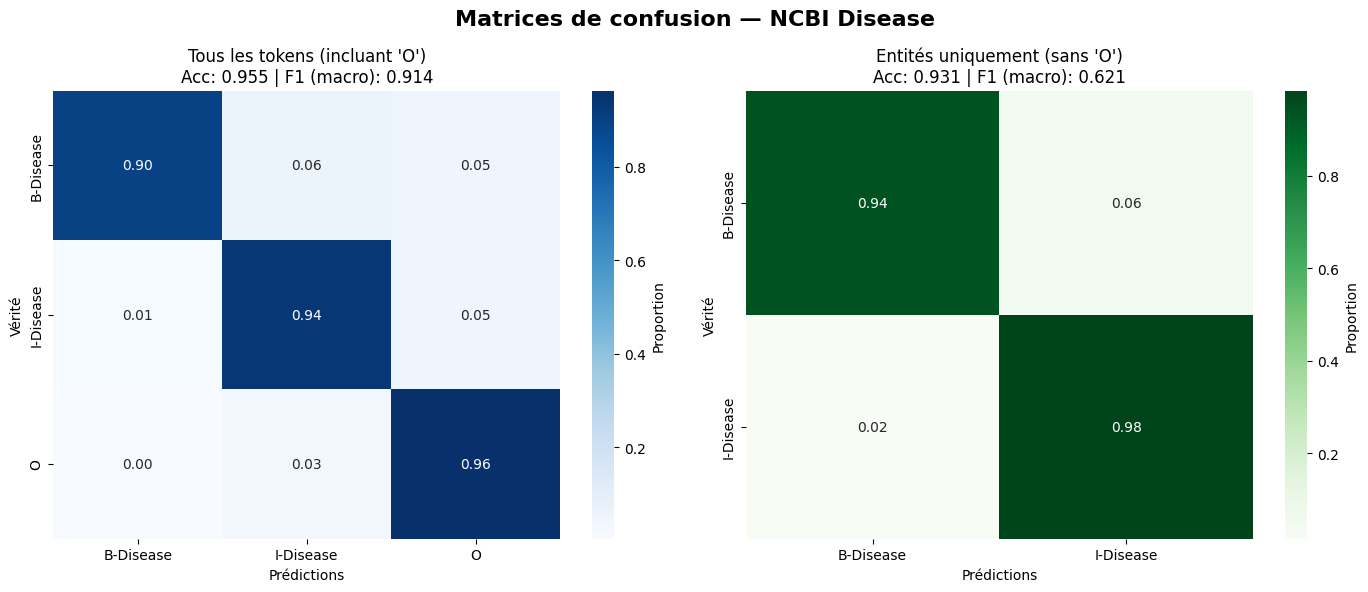

In [21]:
model_path_ncbi = "./checkpoints/NCBI/bioMedModel_fullyConnectedAttention_NCBI.pt"
model_we_char_cnn_bilstm_attention_fc_ncbi, device, idx_to_tag_ncbi = load_trained_model(
    model_path=model_path_ncbi,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=True,use_char_lstm=True,use_attention=True,use_fc_fusion=True
)

test_loader_ncbi = results_ncbi['test_loader']
predictions_we_char__bilstm_cnn_attention_fc_ncbi, targets_we_char__bilstm_cnn_attention_fc_ncbi = predict_on_test_set(
    model=model_we_char_cnn_bilstm_attention_fc_ncbi,
    test_loader=test_loader_ncbi,
    device=device,
    idx_to_tag=idx_to_tag_ncbi
)

# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_attention_fc_ncbi, predictions_we_char__bilstm_cnn_attention_fc_ncbi)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char__bilstm_cnn_attention_fc_ncbi, targets_we_char__bilstm_cnn_attention_fc_ncbi) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char__bilstm_cnn_attention_fc_ncbi, targets_we_char__bilstm_cnn_attention_fc_ncbi) if t != 'O']

if set(predictions_we_char__bilstm_cnn_attention_fc_ncbi) == set(targets_we_char__bilstm_cnn_attention_fc_ncbi) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_attention_fc_ncbi):
    ncbi_metrics  = plot_confusion_matrix_by_class(
    predictions_we_char__bilstm_cnn_attention_fc_ncbi,
    targets_we_char__bilstm_cnn_attention_fc_ncbi,
    idx_to_tag_ncbi,
    dataset_name="NCBI Disease"
)
    
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_attention_fc_ncbi[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_attention_fc_ncbi[:10])}")

# Tests :

### JNLPBA

In [22]:
import torch

# ─────────────────────────────────────────────
# 1. Chargement checkpoint
# ─────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint_path = "./checkpoints/JNLPBA/bioMedModel_fullyConnectedAttention_JNLPBA.pt"
ckpt = torch.load(checkpoint_path, map_location=device)

# ─────────────────────────────────────────────
# 2. Récupération EXACTE des objets du training
# ─────────────────────────────────────────────
# Ces objets doivent venir des loaders utilisés à l'entraînement
train_loader = results_jnlpba["train_loader"]
vocab        = results_jnlpba["vocab"]
char_vocab   = results_jnlpba["char_vocab"]
tag_to_idx   = results_jnlpba["tag_to_idx"]
idx_to_tag   = results_jnlpba["idx_to_tag"]

# ─────────────────────────────────────────────
# 3. Reconstruction du modèle (IDENTIQUE au training)
# ─────────────────────────────────────────────
model = CombinatorialNER(
    vocab_size=len(vocab),
    char_vocab_size=len(char_vocab),
    tag_to_idx=tag_to_idx,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    pretrained_embeddings=results_jnlpba["pretrained_embeddings"],
    word_embed_dim=200,
    lstm_hidden_dim=256,   # JNLPBA
    dropout=0.5
).to(device)

model.load_state_dict(ckpt["model_state_dict"])
model.eval()

def token_accuracy(all_preds, all_golds):
    correct = 0
    total = 0
    for preds, golds in zip(all_preds, all_golds):
        for p, g in zip(preds, golds):
            if g != "<PAD>":
                total += 1
                if p == g:
                    correct += 1
    return correct / total

def token_accuracy_single(preds, golds):
    correct = 0
    total = 0
    for p, g in zip(preds, golds):
        if g != "<PAD>":
            total += 1
            if p == g:
                correct += 1
    return correct / total if total > 0 else 0.0


# ─────────────────────────────────────────────
# 4. Fonction de prédiction CORRECTE
# ─────────────────────────────────────────────
def predict_sentence(
    model,
    sentence,
    vocab,
    char_vocab,
    idx_to_tag,
    device,
    max_seq_len=100,
    max_char_len=20
):
    model.eval()

    PAD_WORD = vocab["<PAD>"]
    UNK_WORD = vocab["<UNK>"]
    PAD_CHAR = char_vocab["<PAD>"]
    UNK_CHAR = char_vocab["<UNK>"]

    # 1. Troncature
    tokens = sentence[:max_seq_len]
    seq_len = len(tokens)

    # 2. Word IDs
    word_ids = [vocab.get(w.lower(), UNK_WORD) for w in tokens]
    word_ids += [PAD_WORD] * (max_seq_len - seq_len)

    # 3. Char IDs
    char_seqs = []
    for w in tokens:
        chars = [char_vocab.get(c, UNK_CHAR) for c in w[:max_char_len]]
        chars += [PAD_CHAR] * (max_char_len - len(chars))
        char_seqs.append(chars)

    char_seqs += [[PAD_CHAR] * max_char_len] * (max_seq_len - seq_len)

    # 4. Tensors
    word_tensor = torch.tensor(word_ids).unsqueeze(0).to(device)
    char_tensor = torch.tensor(char_seqs).unsqueeze(0).to(device)

    mask = torch.zeros((1, max_seq_len), dtype=torch.bool).to(device)
    mask[:, :seq_len] = True

    # 5. Inference CRF
    with torch.no_grad():
        predictions = model(word_tensor, char_tensor, mask)
        predicted_ids = predictions[0][:seq_len]

    return [idx_to_tag[i] for i in predicted_ids]



# ─────────────────────────────────────────────
# 5. Tes phrases de test
# ─────────────────────────────────────────────
test_data = [
    # Protein + Cell line
    (
        ["Octamer-binding", "proteins", "from", "HeLa", "cells", "stimulate", "transcription"],
        ["B-protein", "I-protein", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # DNA example
    (
        ["The", "BRCA1", "gene", "is", "associated", "with", "breast", "cancer"],
        ["O", "B-DNA", "O", "O", "O", "O", "B-cell_type", "O"]
    ),
    # RNA example
    (
        ["mRNA", "expression", "in", "Jurkat", "cells", "was", "upregulated"],
        ["B-RNA", "O", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # Cell type example
    (
        ["T", "lymphocytes", "play", "a", "key", "role", "in", "immune", "response"],
        ["B-cell_type", "I-cell_type", "O", "O", "O", "O", "O", "O", "O"]
    ),
    # Overlapping adjacent entities
    (
        ["p53", "and", "BRCA1", "regulate", "DNA", "replication"],
        ["B-protein", "O", "B-DNA", "O", "B-DNA", "O"]
    ),
    # Mixed entities
    (
        ["The", "RNA", "of", "Jurkat", "T", "cells", "is", "similar", "to", "HeLa", "cells"],
        ["O", "B-RNA", "O", "B-cell_line", "B-cell_type", "I-cell_line", "O", "O", "O", "B-cell_line", "I-cell_line"]
    ),
    # Long sentence with multiple types
    (
        ["p53", "protein", "binds", "to", "BRCA1", "DNA", "in", "HeLa", "and", "Jurkat", "cells", "during", "transcription"],
        ["B-protein", "I-protein", "O", "O", "B-DNA", "I-DNA", "O", "B-cell_line", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # DNA + RNA + protein in one sentence
    (
        ["BRCA1", "gene", "transcribes", "mRNA", "which", "produces", "p53", "protein"],
        ["B-DNA", "O", "O", "B-RNA", "O", "O", "B-protein", "I-protein"]
    ),
]

# ─────────────────────────────────────────────
# 6. Évaluation lisible
# ─────────────────────────────────────────────
all_preds = []
all_golds = []

for i, (sentence, gold) in enumerate(test_data, 1):
    preds = predict_sentence(model, sentence, vocab, char_vocab, idx_to_tag, device)

    all_preds.append(preds)
    all_golds.append(gold)

    # Accuracy par phrase
    acc_sentence = token_accuracy_single(preds, gold)

    print(f"Example {i}")
    print(f"{'Token':15s} {'Gold':15s} {'Predicted':15s}")
    print("-" * 50)
    for t, g, p in zip(sentence, gold, preds):
        print(f"{t:15s} {g:15s} {p:15s}")

    print(f"\nToken accuracy (sentence): {acc_sentence:.4f}")
    print("=" * 60 + "\n")

# Accuracy globale
acc_global = token_accuracy(all_preds, all_golds)
print(f"Global token accuracy: {acc_global:.4f}")




Example 1
Token           Gold            Predicted      
--------------------------------------------------
Octamer-binding B-protein       B-protein      
proteins        I-protein       I-protein      
from            O               O              
HeLa            B-cell_line     B-cell_line    
cells           I-cell_line     I-cell_line    
stimulate       O               O              
transcription   O               O              

Token accuracy (sentence): 1.0000

Example 2
Token           Gold            Predicted      
--------------------------------------------------
The             O               O              
BRCA1           B-DNA           B-DNA          
gene            O               I-DNA          
is              O               O              
associated      O               O              
with            O               O              
breast          B-cell_type     O              
cancer          O               O              

Token accuracy (sentence)

C:\Users\oumak\AppData\Local\Temp\ipykernel_19008\2938528065.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


### NCBI

In [23]:
import torch

# ─────────────────────────────────────────────
# 1. Chargement checkpoint
# ─────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint_path = "./checkpoints/NCBI/bioMedModel_fullyConnectedAttention_NCBI.pt"
ckpt = torch.load(checkpoint_path, map_location=device)

# ─────────────────────────────────────────────
# 2. Récupération EXACTE des objets du training
# ─────────────────────────────────────────────
# Ces objets doivent venir des loaders utilisés à l'entraînement
train_loader = results_ncbi["train_loader"]
vocab        = results_ncbi["vocab"]
char_vocab   = results_ncbi["char_vocab"]
tag_to_idx   = results_ncbi["tag_to_idx"]
idx_to_tag   = results_ncbi["idx_to_tag"]

# ─────────────────────────────────────────────
# 3. Reconstruction du modèle (IDENTIQUE au training)
# ─────────────────────────────────────────────
model = CombinatorialNER(
    dataset="NCBI",
    vocab_size=len(vocab),
    char_vocab_size=len(char_vocab),
    tag_to_idx=tag_to_idx,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    pretrained_embeddings=results_ncbi["pretrained_embeddings"],
    word_embed_dim=200,
    lstm_hidden_dim=128,   # JNLPBA
    dropout=0.5
).to(device)

model.load_state_dict(ckpt["model_state_dict"])
model.eval()

def token_accuracy(all_preds, all_golds):
    correct = 0
    total = 0
    for preds, golds in zip(all_preds, all_golds):
        for p, g in zip(preds, golds):
            if g != "<PAD>":
                total += 1
                if p == g:
                    correct += 1
    return correct / total

def token_accuracy_single(preds, golds):
    correct = 0
    total = 0
    for p, g in zip(preds, golds):
        if g != "<PAD>":
            total += 1
            if p == g:
                correct += 1
    return correct / total if total > 0 else 0.0


# ─────────────────────────────────────────────
# 4. Fonction de prédiction CORRECTE
# ─────────────────────────────────────────────
def predict_sentence(
    model,
    sentence,
    vocab,
    char_vocab,
    idx_to_tag,
    device,
    max_seq_len=100,
    max_char_len=20
):
    model.eval()

    PAD_WORD = vocab["<PAD>"]
    UNK_WORD = vocab["<UNK>"]
    PAD_CHAR = char_vocab["<PAD>"]
    UNK_CHAR = char_vocab["<UNK>"]

    # 1. Troncature
    tokens = sentence[:max_seq_len]
    seq_len = len(tokens)

    # 2. Word IDs
    word_ids = [vocab.get(w.lower(), UNK_WORD) for w in tokens]
    word_ids += [PAD_WORD] * (max_seq_len - seq_len)

    # 3. Char IDs
    char_seqs = []
    for w in tokens:
        chars = [char_vocab.get(c, UNK_CHAR) for c in w[:max_char_len]]
        chars += [PAD_CHAR] * (max_char_len - len(chars))
        char_seqs.append(chars)

    char_seqs += [[PAD_CHAR] * max_char_len] * (max_seq_len - seq_len)

    # 4. Tensors
    word_tensor = torch.tensor(word_ids).unsqueeze(0).to(device)
    char_tensor = torch.tensor(char_seqs).unsqueeze(0).to(device)

    mask = torch.zeros((1, max_seq_len), dtype=torch.bool).to(device)
    mask[:, :seq_len] = True

    # 5. Inference CRF
    with torch.no_grad():
        predictions = model(word_tensor, char_tensor, mask)
        predicted_ids = predictions[0][:seq_len]

    return [idx_to_tag[i] for i in predicted_ids]



test_data = [
    # Example 1
    (["the", "hereditary", "breast", "and", "ovarian", "cancer", "syndrome", "is", "associated", "with", "a", "high", "frequency", "of", "brca1", "mutations", "."],
     ["O", "B-Disease", "I-Disease", "I-Disease", "I-Disease", "I-Disease", "I-Disease", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O"]),

    # Example 2
    (["patients", "with", "BRCA1", "mutation", "show", "increased", "risk"],
     ["O", "O", "B-Disease", "I-Disease", "O", "O", "O"]),

    # Example 3
    (["the", "prevalence", "of", "hereditary", "breast", "cancer", "is", "high", "in", "certain", "populations"],
     ["O", "O", "O", "B-Disease", "I-Disease", "I-Disease", "O", "O", "O", "O", "O"])
]




# ─────────────────────────────────────────────
# 6. Évaluation lisible
# ─────────────────────────────────────────────
all_preds = []
all_golds = []

for i, (sentence, gold) in enumerate(test_data, 1):
    preds = predict_sentence(model, sentence, vocab, char_vocab, idx_to_tag, device)

    all_preds.append(preds)
    all_golds.append(gold)

    # Accuracy par phrase
    acc_sentence = token_accuracy_single(preds, gold)

    print(f"Example {i}")
    print(f"{'Token':15s} {'Gold':15s} {'Predicted':15s}")
    print("-" * 50)
    for t, g, p in zip(sentence, gold, preds):
        print(f"{t:15s} {g:15s} {p:15s}")

    print(f"\nToken accuracy (sentence): {acc_sentence:.4f}")
    print("=" * 60 + "\n")

# Accuracy globale
acc_global = token_accuracy(all_preds, all_golds)
print(f"Global token accuracy: {acc_global:.4f}")

Example 1
Token           Gold            Predicted      
--------------------------------------------------
the             O               O              
hereditary      B-Disease       B-Disease      
breast          I-Disease       I-Disease      
and             I-Disease       I-Disease      
ovarian         I-Disease       I-Disease      
cancer          I-Disease       I-Disease      
syndrome        I-Disease       I-Disease      
is              O               I-Disease      
associated      O               I-Disease      
with            O               I-Disease      
a               O               I-Disease      
high            O               I-Disease      
frequency       O               I-Disease      
of              O               O              
brca1           O               O              
mutations       O               O              
.               O               O              

Token accuracy (sentence): 0.6471

Example 2
Token           Gold         

C:\Users\oumak\AppData\Local\Temp\ipykernel_19008\1558245796.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)
